# Predicting lipophilicity with a LogD regressor

The data for training this model was taken from deep-pk server: https://biosig.lab.uq.edu.au/deeppk/data, which has logD values for compounds at pH 7.4. Most orally administered drugs have a logD between 1 and 3.

Get all necessary libraries first:

In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem, rdmolops, Draw, Descriptors, rdDepictor, PandasTools, rdMolDescriptors as rdmd;
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import rdkit
print(f"I am RDKit version: {rdkit.__version__}")
import sys
print(f"I am python version {sys.version}")

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


I am RDKit version: 2023.09.5
I am python version 3.10.0 (default, Feb 27 2024, 12:29:18) [Clang 15.0.0 (clang-1500.1.0.2.5)]


# Import and check the data

In [2]:
logd = pd.read_csv("../data/logD.csv")
print(f"The dataset contains {logd.shape[0]} endpoints on LogD")
logd.head(3)

The dataset contains 10629 endpoints on LogD


,smiles_standarized,label,group
0,O=C(Nc1cnn(Cc2ccccc2)c1)c1[nH]nc2c1CCC1(CC1)C2,3.9,test
1,Cc1ccc(C)c2c(=O)c3c([nH]c12)CCCC3,2.6,test
2,O=c1ncn(Cc2ccc(F)cc2F)c2cc(F)c(Oc3ncccc3C(F)(F...,3.9,test


The dataset already contains standardized SMILES and hence we won't perform any of those operations.

In [3]:
# Let's rename the columns to something simple:

logd = logd.rename(columns={"smiles_standarized": "smiles", "label": "logD"})

<Axes: xlabel='logD', ylabel='Count'>

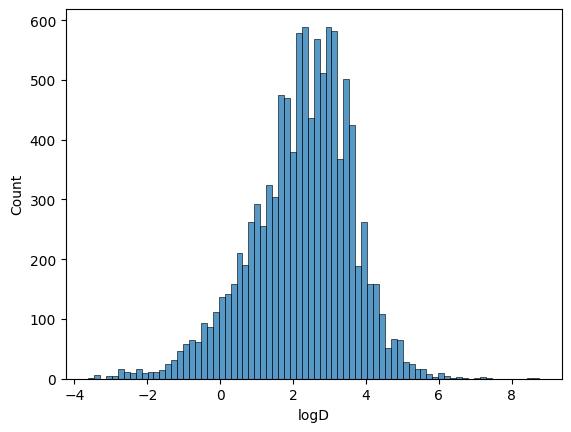

In [4]:
# Let's check the overall distribution:

sns.histplot(logd.logD)

Overall, the logD values span over a range of -3 to 7, with most being between -1 and 5, which is reflective of most drugs and drug-like small molecules

# Compute phys-chem descriptors

In [5]:
import datamol as dm

# Instantiate a descriptor calculator
from molfeat.trans import MoleculeTransformer
from molfeat.calc import RDKitDescriptors2D

desc = RDKitDescriptors2D(replace_nan = True)

# Instantiate a molecule transfomer. This object takes a list of SMILES as input and returns descriptors.
featurizer = MoleculeTransformer(desc, dtype=np.float32)

with dm.without_rdkit_log():
    feats = featurizer(logd.smiles.values)

In [6]:
# A total of 216 2D descriptors are computed:
pd.DataFrame(feats).head(3)

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
0,12.672311,12.672311,0.134483,-0.134483,0.760999,17.076923,347.421997,326.253998,347.174622,132.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,12.526157,12.526157,0.258935,0.258935,0.736937,14.941176,227.307007,210.171005,227.131012,88.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,14.722711,14.722711,0.017925,-4.801170,0.406941,11.687500,451.325989,440.238007,451.075531,164.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## We normalize the features between 0 and 1

In [7]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Initialize
scaler = MinMaxScaler()

# Fit and transform the data
X_normalized = scaler.fit_transform(feats)

# Print the first few rows of the normalized data
print("Normalized Data (MinMaxScaler):")

X_normalized_df = pd.DataFrame(X_normalized)

X_normalized_df.head(3)

Normalized Data (MinMaxScaler):


,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
0,0.694777,0.694777,0.067236,0.819384,0.800096,0.169816,0.374168,0.379783,0.374137,0.353535,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.5,0.000000
1,0.685263,0.685263,0.129462,0.852674,0.774209,0.132337,0.210963,0.211650,0.210917,0.205387,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
2,0.828260,0.828260,0.008956,0.424496,0.419182,0.075240,0.515347,0.544876,0.515409,0.461279,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.166667


## Now we drop features that are highly correlated

In [8]:
from feature_engine.selection import DropCorrelatedFeatures

dcf = DropCorrelatedFeatures(threshold=0.9) # One can play with the threshold here:

corr_removed = dcf.fit_transform(X_normalized_df)

corr_removed.head(3)


,0,2,3,4,5,6,10,11,12,15,...,205,206,207,208,209,210,211,212,214,215
0,0.694777,0.067236,0.819384,0.800096,0.169816,0.374168,0.0,0.403575,0.671780,0.55335,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.000000
1,0.685263,0.129462,0.852674,0.774209,0.132337,0.210963,0.0,0.248972,0.623573,0.45351,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.828260,0.008956,0.424496,0.419182,0.075240,0.515347,0.0,0.685436,0.529612,0.40121,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667


In [24]:
# logd_refined = pd.concat([logd, corr_removed], axis=1)
# logd_refined.shape
# logd_refined.to_csv("../data/logD_normalizedDescriptors.csv")

## Test-train splitting and model building

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor

X = corr_removed # put features in a dataframe called X
y = logd.logD # put features in series y

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=0)

# Initiate the LightGBM regressor:
gbm = HistGradientBoostingRegressor()

# Fit the training data:
gbm.fit(X_train, y_train)

# Predict logD of the testing set:
y_pred = gbm.predict(X_test)

# Show top 10 predictions
y_pred[:10]

array([-1.49525691,  4.30778696,  3.09195337,  2.11749045,  0.58475292,
        1.57174447,  2.72130664,  2.16757147,  2.55526206,  4.26857886])

In [10]:
# Evaluate the model's predictions:

from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score
from scipy.stats import pearsonr

mse_gbm = mean_squared_error(y_test, y_pred)
rmse_gbm = root_mean_squared_error(y_test, y_pred)
r2_gbm = r2_score(y_test, y_pred)
pearson_corr = pearsonr(y_test, y_pred)

print(f"MSE: {mse_gbm}")
print(f"RMSE: {rmse_gbm}")
print(f"R2 score: {r2_gbm}")
print(f"Pearson correlation coefficient: {pearson_corr[0]}")

MSE: 0.3159209638955675
RMSE: 0.5620684690458695
R2 score: 0.8339513834784699
Pearson correlation coefficient: 0.9153759078743227


<Axes: xlabel='logD'>

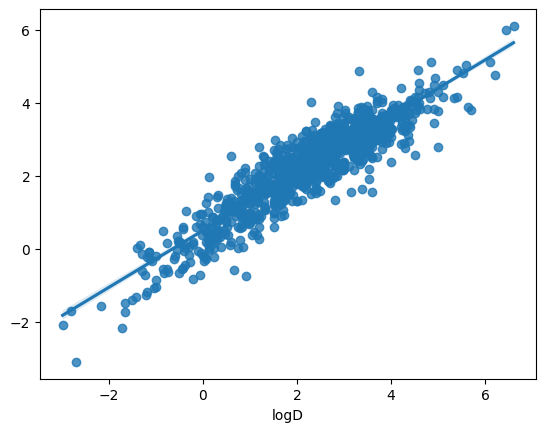

In [11]:
sns.regplot(x=y_test, y=y_pred)

# Save model

In [12]:
import joblib

joblib.dump(gbm, '../saved_models/logD_regressor.model')

# Load the saved model:

load_model = joblib.load('../saved_models/logD_regressor.model')

# Define a featurization function for carrying out predictions

Before model training, we removed the highly correlated features from the training dataset. 

We need to make sure that the molecules whose values we wish to predict also contain the same number of feature columns. 

Hence we define the following function to remove those features:

In [13]:
def featurizer_df(df_a, df_b):
    
    #dataframe df_a will be the one containing test molecules. It will contain more features than those in the training dataset
    #dataframe df_b will be the one whose correlated features are removed before model training
    
    # Get column names from both DataFrames
    columns_a = set(df_a.columns)
    columns_b = set(df_b.columns)

    # Identify columns in A not present in B
    columns_to_remove = columns_a - columns_b
    
    # Remove those columns from DataFrame A
    df_a.drop(columns=columns_to_remove, inplace=True)
    
    return df_a

In [14]:
load_model.predict(featurizer_df(pd.DataFrame(featurizer('CC(C)C(C(=O)N1CCCC1C2=NC=C(N2)C3=CC=C(C=C3)C4=CC=C(C=C4)C5=CN=C(N5)C6CCCN6C(=O)C(C(C)C)NC(=O)OC)NC(=O)OC')), corr_removed))[0]

[13:12:05] Initializing MetalDisconnector
[13:12:05] Running MetalDisconnector
[13:12:05] Initializing Normalizer
[13:12:05] Running Normalizer
[13:12:05] Initializing MetalDisconnector
[13:12:05] Running MetalDisconnector
[13:12:05] Initializing Normalizer
[13:12:05] Running Normalizer


5.480989852147478

# Predict logD values of smiles in a Dataframe

In [15]:
 # define a sample dataframe

sample_df = pd.DataFrame({          
    'ID':[1, 2],
    'smiles': ['c1ccccc1N', 'CCON']
    })

sample_df

,ID,smiles
0,1,c1ccccc1N
1,2,CCON


In [16]:
# Define a function to return the predicted logD:

def predict_logD(smiles):
    
    return load_model.predict(featurizer_df(pd.DataFrame(featurizer(smiles)), corr_removed)).item()

In [17]:
sample_df['predicted_logD'] = sample_df['smiles'].apply(predict_logD)

[13:12:05] Initializing MetalDisconnector
[13:12:05] Running MetalDisconnector
[13:12:05] Initializing Normalizer
[13:12:05] Running Normalizer
[13:12:05] Initializing MetalDisconnector
[13:12:05] Running MetalDisconnector
[13:12:05] Initializing Normalizer
[13:12:05] Running Normalizer
[13:12:05] Initializing MetalDisconnector
[13:12:05] Running MetalDisconnector
[13:12:05] Initializing Normalizer
[13:12:05] Running Normalizer
[13:12:05] Initializing MetalDisconnector
[13:12:05] Running MetalDisconnector
[13:12:05] Initializing Normalizer
[13:12:05] Running Normalizer


In [18]:
sample_df

,ID,smiles,predicted_logD
0,1,c1ccccc1N,2.563452
1,2,CCON,-0.374662


# Cross Validation

In [19]:
from sklearn.model_selection import cross_val_score

val = cross_val_score(gbm, X_train, y_train,  scoring='r2', cv=5) 

print(f"validation scores: {val}")

val.mean()

validation scores: [0.81011971 0.83882443 0.82249589 0.80800654 0.81596744]


0.8190828031091281